In [31]:
import dss
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = DSSCircuit.Solution
ControlQueue = DSSCircuit.CtrlQueue
dss_engine.AllowForms = 0

In [32]:
DSSText.Command = "Clear"
DSSText.Command = "New Circuit.33bussystem BasekV=12.66 pu=1 Bus1=1 mvasc3=20000000000"
if not DSSCircuit.Name:
    print("⚠️ Error: No se pudo crear el circuito en OpenDSS.")
else:
    print("✅ Circuito creado correctamente.")
with open("HC_MAX.dss", "r") as file:
    comando_generadores = file.readlines()
with open("IEEE_33_DEMANDAS.dss", "r") as file:
    comando_cargas = file.readlines()
with open("IEEE_33_LINEAS.dss", "r") as file:
    comando_lineas = file.readlines()
for generator in comando_generadores:
    generator = generator.strip()
    if generator:
        DSSText.Command = generator
print(f"✅ {DSSCircuit.Generators.Count} Generadores cargados correctamente en OpenDSS.")
for linea in comando_lineas:
    linea = linea.strip()
    if linea:
        DSSText.Command = linea
print(f"✅ {DSSCircuit.Lines.Count} Líneas cargadas correctamente en OpenDSS.")
for load in comando_cargas:
    load = load.strip()
    if load:
        DSSText.Command = load
print(f"✅ {DSSCircuit.Loads.Count} Cargas cargadas correctamente en OpenDSS.")
DSSText.Command = "Set VoltageBases=[12.66]"
DSSText.Command = "CalcVoltageBases"
DSSText.Command = "Set ControlMode=OFF"
DSSText.Command = "Set Mode=Snap"
DSSText.Command = "Set LoadModel=PowerFlow"
DSSText.Command = "Solve"
DSSSolution.Solve()
if DSSSolution.Converged:
    print("✅ El circuito se resolvio correctamente")
else:
    print("⚠️ La Solución no converge") 

✅ Circuito creado correctamente.
✅ 33 Generadores cargados correctamente en OpenDSS.
✅ 37 Líneas cargadas correctamente en OpenDSS.
✅ 32 Cargas cargadas correctamente en OpenDSS.
✅ El circuito se resolvio correctamente


In [33]:
line_loss = DSSCircuit.LineLosses
print("\n📢 Resultados pérdidas de potencia:")
print(f"🔌Pérdidas Potencia Activa (P) = {round(abs(line_loss[0]), 3)} kW")
print(f"🔌Pérdidas Potencia reactiva (Q) = {round(abs(line_loss[1]), 3)} kVAr")


total_active_power = DSSCircuit.TotalPower[0]
total_reactive_power = DSSCircuit.TotalPower[1]

print(f"⚡ Potencia Activa Total: {total_active_power / 1000:.3f} MW")
print(f"⚡ Potencia Reactiva Total: {total_reactive_power / 1000:.3f} Mvar")


📢 Resultados pérdidas de potencia:
🔌Pérdidas Potencia Activa (P) = 231.566 kW
🔌Pérdidas Potencia reactiva (Q) = 160.371 kVAr
⚡ Potencia Activa Total: 4.585 MW
⚡ Potencia Reactiva Total: -2.460 Mvar


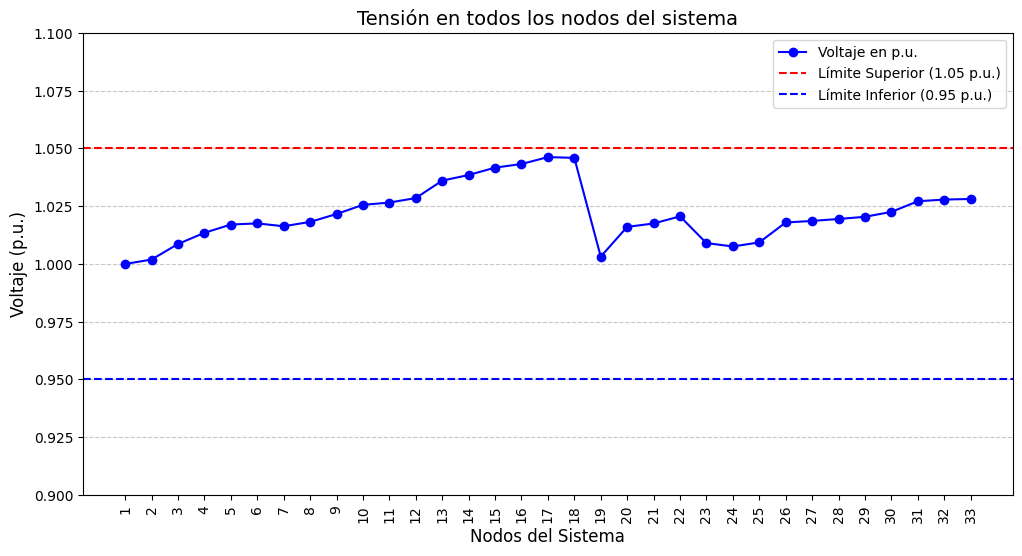

⚡ Voltaje Máximo: 1.0463 p.u. en el nodo 17
⚡ Voltaje Mínimo: 1.0000 p.u. en el nodo 1


In [34]:
bus_names = []
voltages_pu = []
for bus in DSSCircuit.Buses:
    bus_names.append(bus.Name)
    voltages_pu.append(bus.puVmagAngle[0])
plt.figure(figsize=(12, 6))
plt.plot(bus_names, voltages_pu, marker='o', linestyle='-', color='b', label="Voltaje en p.u.")
plt.axhline(y=1.05, color='r', linestyle='dashed', label="Límite Superior (1.05 p.u.)")
plt.axhline(y=0.95, color='b', linestyle='dashed', label="Límite Inferior (0.95 p.u.)")
plt.ylim(0.90, 1.10)
plt.xlabel("Nodos del Sistema", fontsize=12)
plt.ylabel("Voltaje (p.u.)", fontsize=12)
plt.title("Tensión en todos los nodos del sistema", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
max_voltage = max(voltages_pu)
min_voltage = min(voltages_pu)
# Obtener los nodos donde ocurren estos valores
max_bus = bus_names[voltages_pu.index(max_voltage)]
min_bus = bus_names[voltages_pu.index(min_voltage)]
# Imprimir resultados
print(f"⚡ Voltaje Máximo: {max_voltage:.4f} p.u. en el nodo {max_bus}")
print(f"⚡ Voltaje Mínimo: {min_voltage:.4f} p.u. en el nodo {min_bus}")

✅ Hosting Capacity (HC): 8531.07 kW


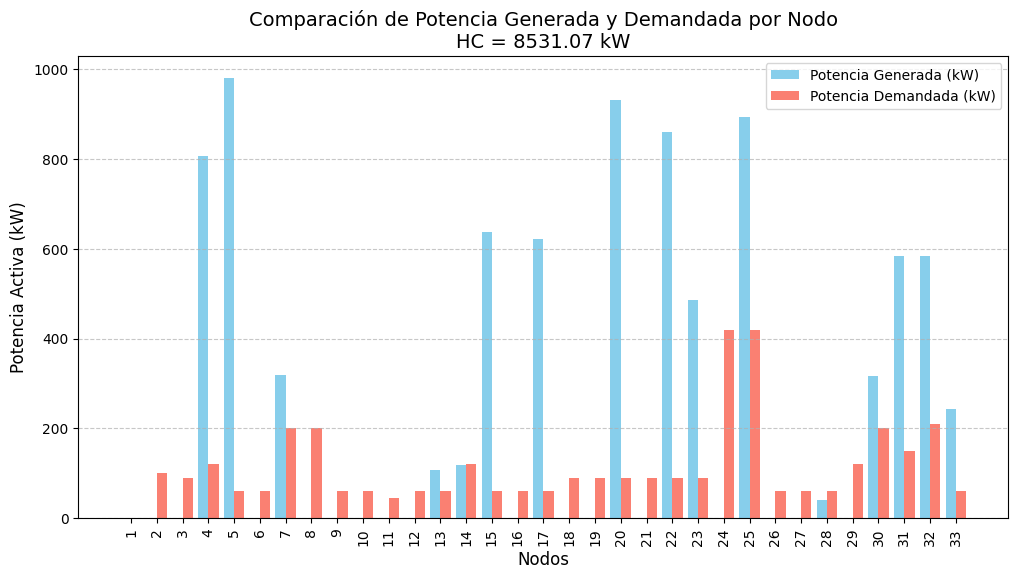

In [35]:
generator_names = DSSCircuit.Generators.AllNames
load_names = DSSCircuit.Loads.AllNames

generator_power = []
generator_buses = []
load_power = []

# Obtener potencia generada y los buses de los generadores
for gen in generator_names:
    DSSCircuit.Generators.Name = gen
    generator_power.append(DSSCircuit.Generators.kW)
    generator_buses.append(DSSCircuit.Generators.Bus1.split('.')[0])  # Extraer solo el nodo

# Calcular el HC como la suma de la potencia generada
HC = sum(generator_power)
print(f"✅ Hosting Capacity (HC): {HC:.2f} kW")

# Inicializar diccionario para almacenar la potencia demandada por cada nodo
load_power_dict = {bus: 0 for bus in generator_buses}

# Recorrer todas las cargas y acumular la potencia demandada en los buses de generadores
for load in load_names:
    DSSCircuit.Loads.Name = load
    load_bus = DSSCircuit.ActiveElement.BusNames[0]

    if load_bus in load_power_dict:
        load_power_dict[load_bus] += DSSCircuit.Loads.kW

# Extraer los valores de carga en el mismo orden que los generadores
load_power = [load_power_dict[bus] for bus in generator_buses]

# Graficar resultados
x = np.arange(len(generator_buses))
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, generator_power, width=0.4, color='skyblue', label="Potencia Generada (kW)")
plt.bar(x + 0.2, load_power, width=0.4, color='salmon', label="Potencia Demandada (kW)")

plt.xlabel("Nodos", fontsize=12)
plt.ylabel("Potencia Activa (kW)", fontsize=12)
plt.title(f"Comparación de Potencia Generada y Demandada por Nodo\nHC = {HC:.2f} kW", fontsize=14)
plt.xticks(x, generator_buses, rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [36]:
V_base = 12.66  # kV
S_base = 1  # MVA
Z_base = (V_base ** 2) / S_base  # Ohm
I_base = S_base / (1.732 * V_base)  # kA

# Obtener los nombres de todas las líneas
line_names = DSSCircuit.Lines.AllNames

# Listas para almacenar datos
line_data = []
bus_from_list = []
bus_to_list = []

# Iterar sobre todas las líneas
for line in line_names:
    DSSCircuit.Lines.Name = line  # Seleccionar línea actual
    
    bus_from = DSSCircuit.Lines.Bus1.split('.')[0]  # Nodo inicial
    bus_to = DSSCircuit.Lines.Bus2.split('.')[0]  # Nodo final
    r_ohm = DSSCircuit.Lines.R1  # Resistencia en ohmios
    x_ohm = DSSCircuit.Lines.X1  # Reactancia en ohmios
    i_max = DSSCircuit.Lines.NormAmps  # Corriente nominal máxima en A
    
    # Convertir a p.u.
    r_pu = r_ohm / Z_base
    x_pu = x_ohm / Z_base
    i_pu = i_max / I_base
    
    # Guardar datos
    line_data.append([int(bus_from), int(bus_to), line, round(r_pu, 8), round(x_pu, 8), round(i_pu, 5)])
    bus_from_list.append(bus_from)
    bus_to_list.append(bus_to)

# Crear DataFrame
df_lines = pd.DataFrame(line_data, columns=["Desde", "Hasta", "Línea", "R (pu)", "X (pu)", "Imax (pu)"])

# Imprimir tabla formateada
print("\nparam :     Ol:     linea       R               X              Imax:=")
for _, row in df_lines.iterrows():
    print(f"  {row['Desde']:>5}  {row['Hasta']:>5}  {row['Línea']:>10}  {row['R (pu)']:>15}  {row['X (pu)']:>15}  {row['Imax (pu)']:>10}")

# Guardar en un archivo CSV
df_lines.to_csv("IEEE_33_LINEAS_PU.csv", index=False)
print("✅ Datos exportados a IEEE_33_LINEAS_PU.csv")



param :     Ol:     linea       R               X              Imax:=
      1      2         1-2       0.00057526       0.00029324    8770.848
      2      3         2-3       0.00307595       0.00156668    8770.848
      3      4         3-4       0.00228357         0.001163    8770.848
      4      5         4-5       0.00237778       0.00121104    8770.848
      5      6         5-6       0.00510995       0.00441115    8770.848
      6      7         6-7       0.00116799       0.00386085    8770.848
      7      8         7-8        0.0044386       0.00146685    8770.848
      8      9         8-9       0.00642643       0.00461705    8770.848
      9     10        9-10       0.00651378       0.00461705    8770.848
     10     11       10-11       0.00122664       0.00040555    8770.848
     11     12       11-12       0.00233598       0.00077242    8770.848
     12     13       12-13       0.00915922       0.00720634    8770.848
     13     14       13-14       0.00337918       0.0